# Script directory
- @author: Jiacheng Lang
- loading packages
- preprocessing
    - text pre-processing
    - directory processing
- LDA model training and selection
    - automatic selection: coherence score calculation
        - select the number of topics
        - remove frequency words from dictionary
    - manuelly validate the model by pyLDAvis
- Visualization
    - topic distributions of subgenres
    - wordcloud of genres

# Loading packages

In [2]:
import os
import string
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk import ne_chunk
from nltk.tree import Tree
from pprint import pprint
import spacy

C:\anaconda\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\anaconda\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
from gensim.models import LdaModel
from gensim.models import CoherenceModel
from gensim import corpora
from gensim import models
import pyLDAvis.gensim
from sklearn.decomposition import PCA

In [4]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

# Text Pre-processing

In [5]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [6]:
speicial_stopwords = ['eveena', 'hendricks', 'darrow', 'cavor', 'mr', 'raymond', 'alice', 'paul', 'herbert', 'besty', 'charles', 'john', 'mahars', 'perry', 'thou', 'felix', 'bruce', 'ruth', 'marjorie', 'joey', 'jack', 'leon', 'tom', 'rodney', 'bob', 'lucy', 'ivar', 'elma', 'effie','yes','dick','bobby','bob','princess','jacquette','joe','jasper','walter','richard','alizon','sir','rodvard','maxwell','nicholas','mavis','gerald','jane','jimmy','mabel','harry','henry','hjalmar','phillips','jean','winthrop','lalette','bertrand','cyril','hortensia','zankiwank','melville','thee','hjalmar','phillips','jean','tressa','chatterton','rideau','robert','hamar','david','varney','tuppence','george']

In [7]:
# text preprocess function
def preprocess_text(text):
    tokens = text.split()
    stop_words = set(stopwords.words('english'))
    tokens_without_stopwords = [word for word in tokens if word not in stop_words]
    pos_tags = pos_tag(tokens_without_stopwords)
    nouns = [token for token, tag in pos_tags if tag.startswith('N')]
    lemmatizer = WordNetLemmatizer()
    lemmatized_nouns = [lemmatizer.lemmatize(word, pos='n') for word in nouns]
    #lemmatized_tokens = [lemmatizer.lemmatize(token, pos=get_wordnet_pos(tag)) for token, tag in pos_tags]
    without_speicalstopword = [token for token in lemmatized_nouns if token not in speicial_stopwords]
    return without_speicalstopword

In [8]:
# example book PG30371
with open('Genrecorpus/sciencefiction/Subgenre_Robots/PG30371_tokens.txt', 'r') as file:
    text = file.read()
tokens = text.split()
len(tokens)

1165

In [9]:
# the result of preprocessing on book PG30371
preprocessed_tokens = preprocess_text(text)
print(preprocessed_tokens)
len(preprocessed_tokens)

['illustration', 'service', 'smile', 'robot', 'lady', 'command', 'indicating', 'perfect', 'martini', 'silver', 'tray', 'permanent', 'porcelain', 'face', 'martini', 'thank', 'dammit', 'smile', 'sorry', 'way', 'voice', 'stood', 'tray', 'deposit', 'tray', 'sand', 'cocktail', 'glass', 'earth', 'chemical', 'gin', 'vermouth', 'ice', 'chill', 'thera', 'wistfully', 'mud', 'hut', 'man', 'mansion', 'woman', 'room', 'house', 'anything', 'earth', 'rug', 'furniture', 'painting', 'wall', 'shelf', 'booktapes', 'musictapes', 'booktapes', 'musictapes', 'spaceship', 'manless', 'world', 'hair', 'finger', 'mirror', 'see', 'trap', 'ship', 'layer', 'prevents', 'message', 'colony', 'colony', 'perpetuates', 'colony', 'men', 'woman', 'woman', 'space', 'space', 'year', 'half', 'year', 'half', 'planet', 'sun', 'robot', 'obedient', 'versatile', 'house', 'food', 'anything', 'element', 'air', 'water', 'bone', 'men', 'lady', 'wreckage', 'spaceship', 'man', 'order', 'create', 'man', 'corpse', 'perfect', 'detail', 'da

202

## directory processing

In [10]:
# loading documents function
def process_documents(directory):
    documents = []
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            file_path = os.path.join(directory, filename)
            with open(file_path, 'r', encoding='utf-8') as file:
                document_text = file.read()
                tokens = preprocess_text(document_text)
                documents.append(tokens)
    return documents

In [11]:
# directory_path of files of books

# total books
#directory_path_total = 'Genrecorpus/total'

# genre Science Fiction
directory_path_s0 = 'Genrecorpus/sciencefiction/sciencefiction_total'
directory_path_s1 = 'Genrecorpus/sciencefiction/Subgenre_Robots'
directory_path_s2 = 'Genrecorpus/sciencefiction/Subgenre_Timetravel'
directory_path_s3 = 'Genrecorpus/sciencefiction/Subgenre_Utopian_Dystopian'

# genre children
directory_path_c0 = 'Genrecorpus/children/children_total'
directory_path_c1 = 'Genrecorpus/children/Subgenre_Fairy tales'
directory_path_c2 = 'Genrecorpus/children/Subgenre_Historical'
directory_path_c3 = 'Genrecorpus/children/Subgenre_Realistic (School)'

# genre Fantasy
directory_path_f0 = 'Genrecorpus/fantasy/fantasy_total'
directory_path_f1 = 'Genrecorpus/fantasy/Subgenre_Folklore'
directory_path_f2 = 'Genrecorpus/fantasy/Subgenre_Historical'
directory_path_f3 = 'Genrecorpus/fantasy/Subgenre_Supernatural'


In [12]:
def get_files_indices(directory, file_list):
    files = os.listdir(directory)
    files_indices = {}
    
    for file in file_list:
        if file in files:
            file_index = files.index(file)
            files_indices[file] = file_index + 1
        else:
            files_indices[file] = None
    
    return files_indices

In [13]:
def books_index(dictionary):
    books_indices = dictionary
    index = list(books_indices.values())
    index_list = [x-1 for x in index]
    return index_list

## genre index - science fiction

In [14]:
robot = os.listdir(directory_path_s1)
robot_dictonary = get_files_indices(directory_path_s0,robot)
robot_index = books_index(robot_dictonary)

In [20]:
timetravel = os.listdir(directory_path_s2)
timetravel_dictonary = get_files_indices(directory_path_s0,timetravel)
timetravel_index = books_index(timetravel_dictonary)

In [21]:
utopian = os.listdir(directory_path_s3)
utopian_dictonary = get_files_indices(directory_path_s0,utopian)
utopian_index = books_index(utopian_dictonary)

## genre index - children

In [22]:
fairy = os.listdir(directory_path_c1)
fairy_dictonary = get_files_indices(directory_path_c0,fairy)
fairy_index = books_index(fairy_dictonary)

In [23]:
c_historical = os.listdir(directory_path_c2)
c_historical_dictonary = get_files_indices(directory_path_c0,c_historical)
c_historical_index = books_index(c_historical_dictonary)

In [24]:
school = os.listdir(directory_path_c3)
school_dictonary = get_files_indices(directory_path_c0,school)
school_index = books_index(school_dictonary)

## genre index - fantasy

In [25]:
folklore = os.listdir(directory_path_f1)
folklore_dictonary = get_files_indices(directory_path_f0,folklore)
folklore_index = books_index(folklore_dictonary)

In [26]:
f_historical = os.listdir(directory_path_f2)
f_historical_dictonary = get_files_indices(directory_path_f0,f_historical)
f_historical_index = books_index(f_historical_dictonary)

In [27]:
supernatural = os.listdir(directory_path_f3)
supernatural_dictonary = get_files_indices(directory_path_f0,supernatural)
supernatural_index = books_index(supernatural_dictonary)

# LDA model training and selection

In [28]:
# train and return trained LDA model
def return_LDA_model(directory_path, num_topics, passes, remove_frequencyterm_num):
    documents = process_documents(directory_path)
    dictionary = corpora.Dictionary(documents)
    dictionary.filter_n_most_frequent(remove_frequencyterm_num)
    corpus = [dictionary.doc2bow(tokens) for tokens in documents]
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=passes, alpha=0.1, eta='auto', random_state=42)
    return lda_model

In [29]:
# print the output of LDA model
def print_LDA_model(lda_model):
    for topic_id, topic in lda_model.print_topics():
        print(f"Topic {topic_id}: {topic}")

In [30]:
def return_documents(directory):
    documents = process_documents(directory)
    return documents

In [31]:
def return_dictionary(documents):
    dictionary = corpora.Dictionary(documents)
    return dictionary

## test the influence of high-frequency words on LDA model

In [19]:
lda_model_0 = return_LDA_model(directory_path_s0,5,10,0)

In [20]:
lda_model_100 = return_LDA_model(directory_path_s0,5,10,100)

In [16]:
lda_model_200 = return_LDA_model(directory_path_s0,5,10,200)

In [21]:
lda_model_200_2 = return_LDA_model(directory_path_s0,5,20,200)

In [22]:
lda_model_500 = return_LDA_model(directory_path_s0,5,10,500)

In [18]:
# coherence score calculation
documents = return_documents(directory_path_s0)
dictionary = return_dictionary(documents)
lda_model = lda_model_200
coherence_model_lda = CoherenceModel(model=lda_model, texts=documents, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.6873350453016209


In [23]:
# coherence score calculation
documents = return_documents(directory_path_s0)
dictionary = return_dictionary(documents)
lda_model = lda_model_0
coherence_model_lda = CoherenceModel(model=lda_model, texts=documents, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.26598212962395484


In [24]:
# coherence score calculation
documents = return_documents(directory_path_s0)
dictionary = return_dictionary(documents)
lda_model = lda_model_100
coherence_model_lda = CoherenceModel(model=lda_model, texts=documents, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.6309616650641159


In [25]:
# coherence score calculation
documents = return_documents(directory_path_s0)
dictionary = return_dictionary(documents)
lda_model = lda_model_500
coherence_model_lda = CoherenceModel(model=lda_model, texts=documents, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.708351060791314


## find the best topic number for LDA model

In [26]:
documents = process_documents(directory_path_s0)
dictionary = corpora.Dictionary(documents)
corpus = [dictionary.doc2bow(tokens) for tokens in documents]
    
models = []
for num_topics in [5, 10, 15, 20, 25]:
    lda_model = return_LDA_model(directory_path_s0,num_topics,10,200)
    models.append(lda_model)

# compare quality of models
coherence_scores = []
for model in models:
    coherence_model_lda = CoherenceModel(model=model, texts=documents, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    coherence_scores.append(coherence_score)

# output the coherence score of models
for i, score in enumerate(coherence_scores):
    print(f"number {i+1} topic has coherence score of {score}")

number 1 topic has coherence score of 0.6873350453016209
number 2 topic has coherence score of 0.6769419049956183
number 3 topic has coherence score of 0.6598199523816775
number 4 topic has coherence score of 0.663819138071334
number 5 topic has coherence score of 0.6636434060753001


In [27]:
documents = process_documents(directory_path_s0)
dictionary = corpora.Dictionary(documents)
corpus = [dictionary.doc2bow(tokens) for tokens in documents]
    
models = []
for num_topics in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    lda_model = return_LDA_model(directory_path_s0,num_topics,10,200)
    models.append(lda_model)

# compare quality of models
coherence_scores = []
for model in models:
    coherence_model_lda = CoherenceModel(model=model, texts=documents, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    coherence_scores.append(coherence_score)

# output the coherence score of models
for i, score in enumerate(coherence_scores):
    print(f"number {i+1} topic has coherence score of {score}")

number 1 topic has coherence score of 0.6094012287275976
number 2 topic has coherence score of 0.6010003021499655
number 3 topic has coherence score of 0.6465822516087203
number 4 topic has coherence score of 0.6625357570086058
number 5 topic has coherence score of 0.6873350453016209
number 6 topic has coherence score of 0.6794149220027763
number 7 topic has coherence score of 0.6551312905224084
number 8 topic has coherence score of 0.6711267957967009
number 9 topic has coherence score of 0.6568138313473918
number 10 topic has coherence score of 0.6769419049956183


In [28]:
# best
lda_model_t5 = return_LDA_model(directory_path_s0,5,10,200)

In [30]:
lda_model_t6 = return_LDA_model(directory_path_s0,6,10,200)

In [29]:
lda_model_t10 = return_LDA_model(directory_path_s0,10,10,200)

## show pyLDAvis chart for model

In [ ]:
# start pyldavis
lda = lda_model_t10
documents = process_documents(directory_path_s0)
dictionary = corpora.Dictionary(documents)
dictionary.filter_n_most_frequent(200)
corpus = [dictionary.doc2bow(tokens) for tokens in documents]
data = pyLDAvis.gensim.prepare(lda,corpus,dictionary)
pyLDAvis.show(data,open_browser=False,local=False)

Serving to http://127.0.0.1:8889/    [Ctrl-C to exit]


127.0.0.1 - - [20/Mar/2024 22:28:31] "GET / HTTP/1.1" 200 -


# topics distribution

## calculate topics distribution of document and genre

In [47]:
def document_topicd(corpus_bow, doc_index,model):
    corpus_bow = corpus_bow
    doc_index = doc_index  
    doc_bow = corpus_bow[doc_index]  
    doc_topics = model.get_document_topics(doc_bow)

    num_topics = model.num_topics

    topic_probs = {i: 0.0 for i in range(num_topics)}

    for topic_id, topic_prob in doc_topics:
        topic_probs[topic_id] = topic_prob
    
    return topic_probs
    #for topic_id, topic_prob in topic_probs.items():
    #    print(f"Topic {topic_id}: probability={topic_prob}")

In [55]:
def subgenre_score(subgenre_index,corpus_bow,model):
    lists = []
    for index in subgenre_index:
        distribution = document_topicd(corpus_bow, index, model)
        distribution_list = list(distribution.values())
        lists.append(distribution_list)
    
    result = []
    num_lists = len(lists)

    result = [sum(values) / len(values) for values in zip(*lists)]
    return result

In [49]:
def show_distribution(result):
    topics = [f"Topic {i}" for i in range(len(result))]

    plt.bar(topics, result)

    plt.xlabel('Topics')
    plt.ylabel('Distribution')
    plt.title('Topic Distribution of document')

    plt.xticks(rotation='vertical')

    plt.show()

In [53]:
#doc_index = 21
#doc_bow = corpus_bow[doc_index]  # bow of document
#doc_topics = lda_science.get_document_topics(doc_bow)
# print distribution of topic of document
#for topic_id, topic_prob in doc_topics:
#    print(f"Topic {topic_id}: probability={topic_prob}")

In [75]:
distribution = document_topicd(corpus_bow_s, 21, lda_science)
distribution_list = list(distribution.values())
print(distribution_list)

[0.40999264, 0.09207063, 0.22114886, 0.23830087, 0.038486958]


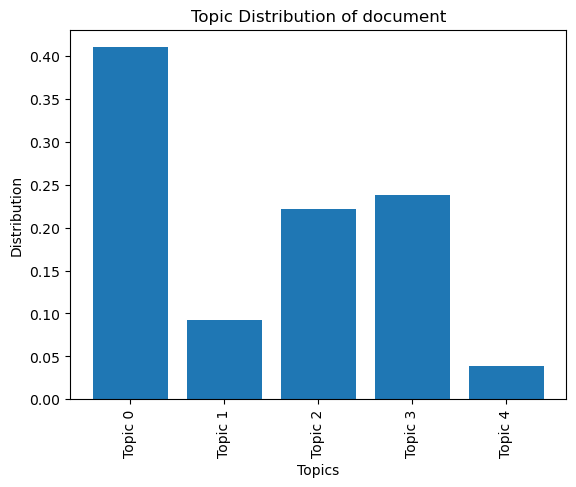

In [76]:
show_distribution(distribution_list)

## genre - science fiction

In [68]:
# prepare bag of words for science fiction documents
documents_s = process_documents(directory_path_s0)
dictionary_s = corpora.Dictionary(documents_s)
corpus_bow_s = [dictionary_s.doc2bow(tokens) for tokens in documents_s]

In [69]:
# LDA model of science fiction
lda_science = return_LDA_model(directory_path_s0,5,10,200)

In [56]:
robot_index = [21, 22, 23, 24, 25, 27, 28, 36, 37, 38]

In [57]:
timetravel_index = [7, 10, 11, 12, 14, 16, 17, 26, 35, 39]

In [58]:
utopia_index = [5, 8, 15, 18, 29, 31, 34, 41, 42]

In [180]:
result_s1 = subgenre_score(robot_index,corpus_bow_s,lda_science)

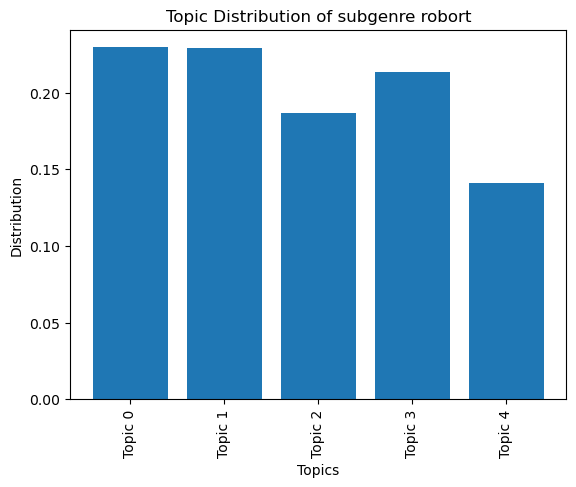

In [181]:
topics = [f"Topic {i}" for i in range(len(result_s1))]

plt.bar(topics, result_s1)

plt.xlabel('Topics')
plt.ylabel('Distribution')
plt.title('Topic Distribution of subgenre robort')

plt.xticks(rotation='vertical')

plt.show()

In [178]:
result_s2 = subgenre_score(timetravel_index,corpus_bow_s,lda_science)

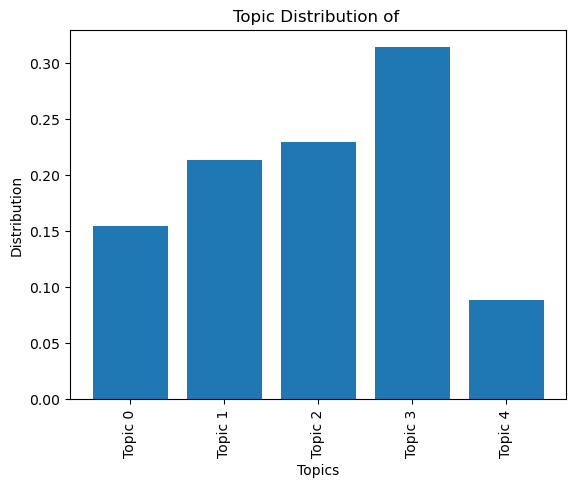

In [179]:
topics = [f"Topic {i}" for i in range(len(result_s2))]

plt.bar(topics, result_s2)

plt.xlabel('Topics')
plt.ylabel('Distribution')
plt.title('Topic Distribution of ')

plt.xticks(rotation='vertical')

plt.show()

In [165]:
utopian_index = utopian_index[:-1]

[5, 8, 15, 18, 29, 31, 34, 41]

In [176]:
result_s3 = subgenre_score(utopian_index,corpus_bow_s,lda_science)

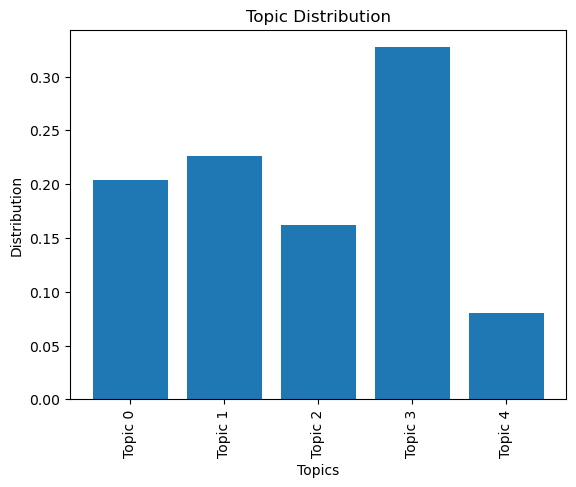

In [177]:
topics = [f"Topic {i}" for i in range(len(result_s3))]

plt.bar(topics, result_s3)

plt.xlabel('Topics')
plt.ylabel('Distribution')
plt.title('Topic Distribution')

plt.xticks(rotation='vertical')

plt.show()

In [344]:
lists1 = []
for index in robot_index:
    distribution = document_topicd(corpus_bow, index, lda_science)
    distribution_list = list(distribution.values())
    lists1.append(distribution_list)

In [345]:
lists2 = []
for index in timetravel_index:
    distribution = document_topicd(corpus_bow, index, lda_science)
    distribution_list = list(distribution.values())
    lists2.append(distribution_list)

In [346]:
lists3 = []
for index in utopia_index:
    distribution = document_topicd(corpus_bow, index, lda_science)
    distribution_list = list(distribution.values())
    lists3.append(distribution_list)

C:\anaconda\lib\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
C:\anaconda\lib\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
C:\anaconda\lib\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
C:\anaconda\lib\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, c

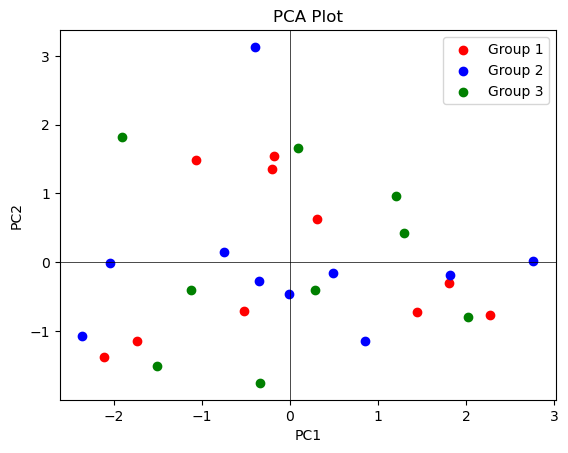

In [347]:

# 主题分数矩阵，每行代表一个文档，每列代表一个主题的分数
topic_scores = pd.DataFrame(lists)
# 三个主题分数矩阵，每个矩阵代表不同组的文档主题分数
topic_scores_1 = pd.DataFrame(lists1)
topic_scores_2 = pd.DataFrame(lists2)
topic_scores_3 = pd.DataFrame(lists3)

# 标准化主题分数矩阵
normalized_scores_1 = (topic_scores_1 - topic_scores_1.mean(axis=0)) / topic_scores_1.std(axis=0)
normalized_scores_2 = (topic_scores_2 - topic_scores_2.mean(axis=0)) / topic_scores_2.std(axis=0)
normalized_scores_3 = (topic_scores_3 - topic_scores_3.mean(axis=0)) / topic_scores_3.std(axis=0)

# 进行PCA降维
pca = PCA(n_components=2)
pca_scores_1 = pca.fit_transform(normalized_scores_1)
pca_scores_2 = pca.fit_transform(normalized_scores_2)
pca_scores_3 = pca.fit_transform(normalized_scores_3)

# 绘制PCA图
plt.scatter(pca_scores_1[:, 0], pca_scores_1[:, 1], color='red', label='Group 1')
plt.scatter(pca_scores_2[:, 0], pca_scores_2[:, 1], color='blue', label='Group 2')
plt.scatter(pca_scores_3[:, 0], pca_scores_3[:, 1], color='green', label='Group 3')

# 添加标题和标签
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Plot')

# 添加图例
plt.legend()

plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)

# 显示图形
plt.show()

## genre - children

In [43]:
documents_c = process_documents(directory_path_c0)
dictionary_c = corpora.Dictionary(documents_c)
corpus_bow_c = [dictionary_c.doc2bow(tokens) for tokens in documents_c]

In [95]:
lda_children = return_LDA_model(directory_path_c0,5,10,200)

In [101]:
fairy_index
c_historical_index = c_historical_index[:-1]
school_index = school_index[:-1]

[11, 12, 13, 14, 21, 22, 26, 27, 32, 35]

In [98]:
result_c1 = subgenre_score(fairy_index,corpus_bow_c,lda_children)

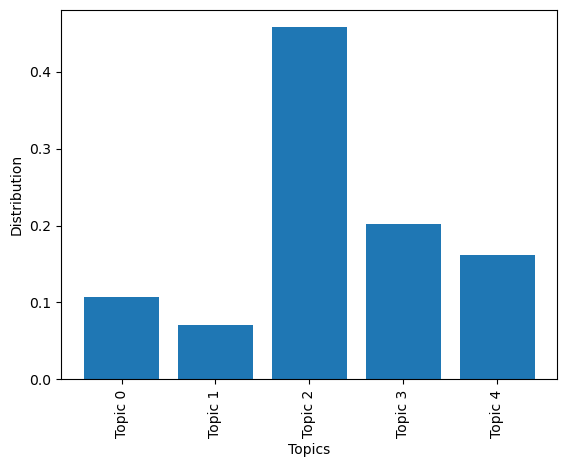

In [99]:
topics = [f"Topic {i}" for i in range(len(result_c1))]
plt.bar(topics, result_c1)
plt.xlabel('Topics')
plt.ylabel('Distribution')
plt.xticks(rotation='vertical')
plt.show()

In [105]:
result_c2 = subgenre_score(c_historical_index,corpus_bow_c,lda_children)

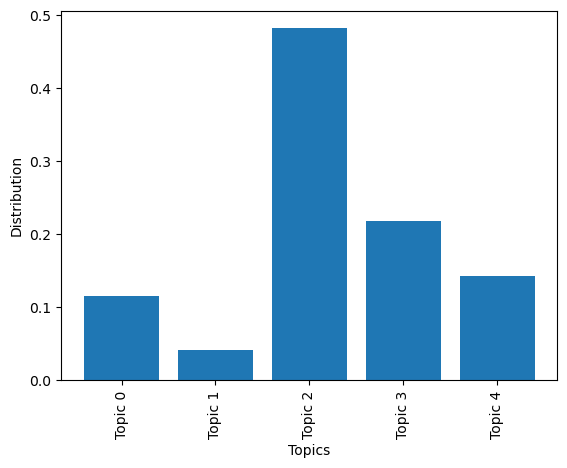

In [106]:
topics = [f"Topic {i}" for i in range(len(result_c2))]
plt.bar(topics, result_c2)
plt.xlabel('Topics')
plt.ylabel('Distribution')
plt.xticks(rotation='vertical')
plt.show()

In [109]:
result_c3 = subgenre_score(school_index,corpus_bow_c,lda_children)

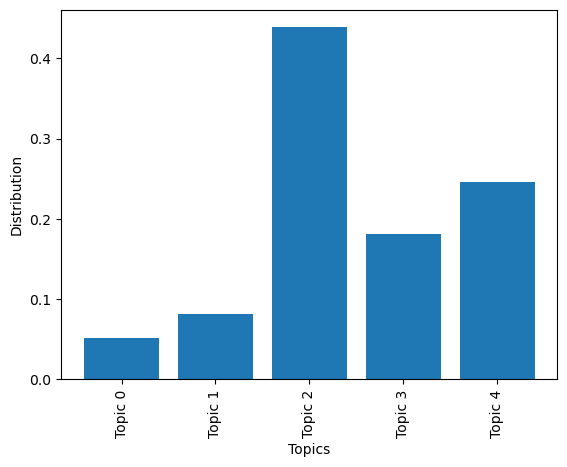

In [110]:
topics = [f"Topic {i}" for i in range(len(result_c3))]
plt.bar(topics, result_c3)
plt.xlabel('Topics')
plt.ylabel('Distribution')
plt.xticks(rotation='vertical')
plt.show()

In [153]:
lists4 = []
for index in fairy_index:
    distribution = document_topicd(corpus_bow_c, index, lda_children)
    distribution_list = list(distribution.values())
    lists4.append(distribution_list)

In [154]:
lists5 = []
for index in c_historical_index:
    distribution = document_topicd(corpus_bow_c, index, lda_children)
    distribution_list = list(distribution.values())
    lists5.append(distribution_list)

In [155]:
lists6 = []
for index in school_index:
    distribution = document_topicd(corpus_bow_c, index, lda_children)
    distribution_list = list(distribution.values())
    lists6.append(distribution_list)

C:\anaconda\lib\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
C:\anaconda\lib\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
C:\anaconda\lib\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
C:\anaconda\lib\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, c

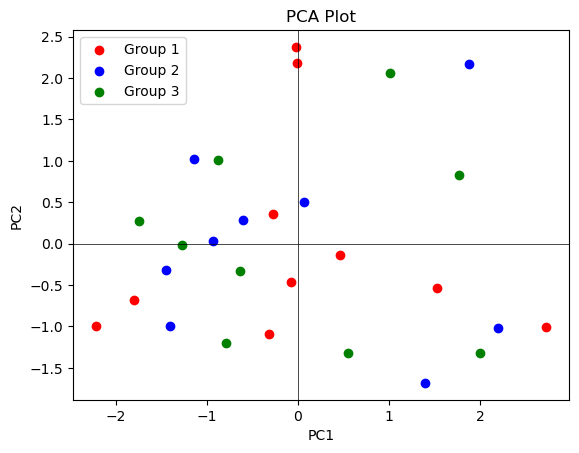

In [158]:
topic_scores = pd.DataFrame(lists)

topic_scores_1 = pd.DataFrame(lists4)
topic_scores_2 = pd.DataFrame(lists5)
topic_scores_3 = pd.DataFrame(lists6)

normalized_scores_1 = (topic_scores_1 - topic_scores_1.mean(axis=0)) / topic_scores_1.std(axis=0)
normalized_scores_2 = (topic_scores_2 - topic_scores_2.mean(axis=0)) / topic_scores_2.std(axis=0)
normalized_scores_3 = (topic_scores_3 - topic_scores_3.mean(axis=0)) / topic_scores_3.std(axis=0)

pca = PCA(n_components=2)
pca_scores_1 = pca.fit_transform(normalized_scores_1)
pca_scores_2 = pca.fit_transform(normalized_scores_2)
pca_scores_3 = pca.fit_transform(normalized_scores_3)

plt.scatter(pca_scores_1[:, 0], pca_scores_1[:, 1], color='red', label='Group 1')
plt.scatter(pca_scores_2[:, 0], pca_scores_2[:, 1], color='blue', label='Group 2')
plt.scatter(pca_scores_3[:, 0], pca_scores_3[:, 1], color='green', label='Group 3')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Plot')

plt.legend()

plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)

plt.show()

## genre - fantasy

In [136]:
documents_f = process_documents(directory_path_f0)
dictionary_f = corpora.Dictionary(documents_f)
corpus_bow_f = [dictionary_f.doc2bow(tokens) for tokens in documents_f]

In [137]:
lda_fantasy = return_LDA_model(directory_path_f0,5,10,200)

In [138]:
f_historical_index = f_historical_index[:-1]

In [139]:
folklore_index

[21, 22, 24, 26, 27, 28, 29, 31, 34, 35]

In [140]:
supernatural_index

[1, 2, 3, 5, 12, 13, 17, 18, 23, 33]

In [141]:
result_f1 = subgenre_score(folklore_index,corpus_bow_f,lda_fantasy)

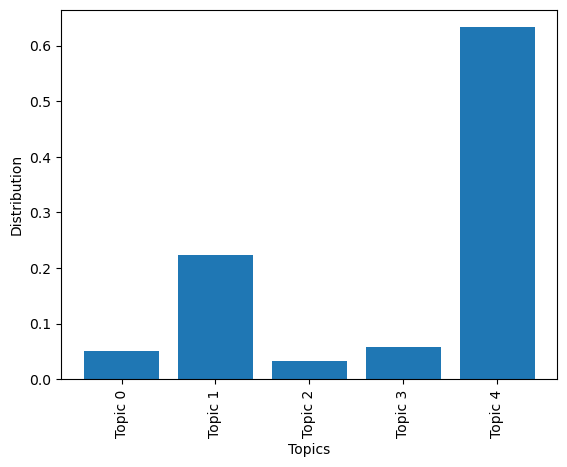

In [149]:
topics = [f"Topic {i}" for i in range(len(result_f1))]
plt.bar(topics, result_f1)
plt.xlabel('Topics')
plt.ylabel('Distribution')
plt.xticks(rotation='vertical')
plt.show()

In [143]:
result_f2 = subgenre_score(f_historical_index,corpus_bow_f,lda_fantasy)

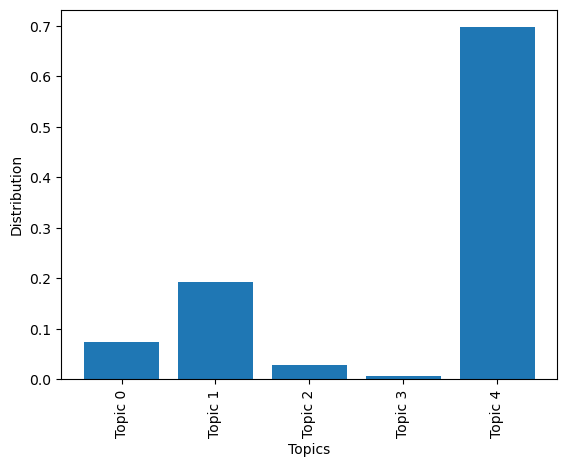

In [150]:
topics = [f"Topic {i}" for i in range(len(result_f2))]
plt.bar(topics, result_f2)
plt.xlabel('Topics')
plt.ylabel('Distribution')
plt.xticks(rotation='vertical')
plt.show()

In [145]:
result_f3 = subgenre_score(supernatural_index,corpus_bow_f,lda_fantasy)

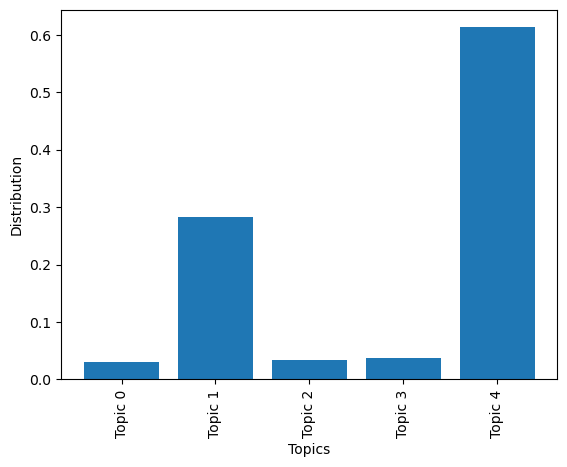

In [151]:
topics = [f"Topic {i}" for i in range(len(result_f3))]
plt.bar(topics, result_f3)
plt.xlabel('Topics')
plt.ylabel('Distribution')
plt.xticks(rotation='vertical')
plt.show()

In [172]:
lists7 = []
for index in folklore_index:
    distribution = document_topicd(corpus_bow_f, index, lda_fantasy)
    distribution_list = list(distribution.values())
    lists7.append(distribution_list)

In [173]:
lists8 = []
for index in f_historical_index:
    distribution = document_topicd(corpus_bow_f, index, lda_fantasy)
    distribution_list = list(distribution.values())
    lists8.append(distribution_list)

In [174]:
lists9 = []
for index in supernatural_index:
    distribution = document_topicd(corpus_bow_f, index, lda_fantasy)
    distribution_list = list(distribution.values())
    lists9.append(distribution_list)

C:\anaconda\lib\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
C:\anaconda\lib\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
C:\anaconda\lib\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
C:\anaconda\lib\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, c

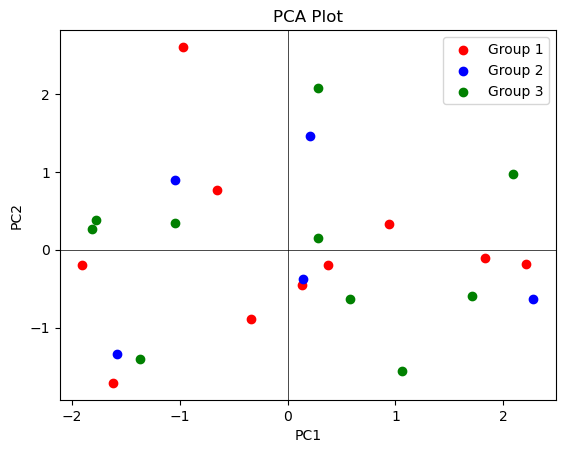

In [175]:
topic_scores = pd.DataFrame(lists)

topic_scores_1 = pd.DataFrame(lists7)
topic_scores_2 = pd.DataFrame(lists8)
topic_scores_3 = pd.DataFrame(lists9)

normalized_scores_1 = (topic_scores_1 - topic_scores_1.mean(axis=0)) / topic_scores_1.std(axis=0)
normalized_scores_2 = (topic_scores_2 - topic_scores_2.mean(axis=0)) / topic_scores_2.std(axis=0)
normalized_scores_3 = (topic_scores_3 - topic_scores_3.mean(axis=0)) / topic_scores_3.std(axis=0)

pca = PCA(n_components=2)
pca_scores_1 = pca.fit_transform(normalized_scores_1)
pca_scores_2 = pca.fit_transform(normalized_scores_2)
pca_scores_3 = pca.fit_transform(normalized_scores_3)

plt.scatter(pca_scores_1[:, 0], pca_scores_1[:, 1], color='red', label='Group 1')
plt.scatter(pca_scores_2[:, 0], pca_scores_2[:, 1], color='blue', label='Group 2')
plt.scatter(pca_scores_3[:, 0], pca_scores_3[:, 1], color='green', label='Group 3')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Plot')

plt.legend()

plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)

plt.show()

# wordcloud of topics

In [81]:
# show LDA model result by wordcloud
def wordcloud(lda_model): 
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
    cloud = WordCloud(stopwords=stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

    topics = lda_model.show_topics(formatted=False)
    fig, axes = plt.subplots(3, 2, figsize=(12, 15), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        if i < len(topics):
            topic_words = dict(topics[i][1])
            cloud.generate_from_frequencies(topic_words, max_font_size=300)
            plt.gca().imshow(cloud)
            plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
            plt.gca().axis('off')
        
    plt.subplots_adjust(wspace=0.2, hspace=0.4)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    fig.savefig('word_cloud.png')
    plt.show()

## wordcloud results

In [ ]:
# children
lda_children = return_LDA_model(directory_path_c0, 5, 10, 200)

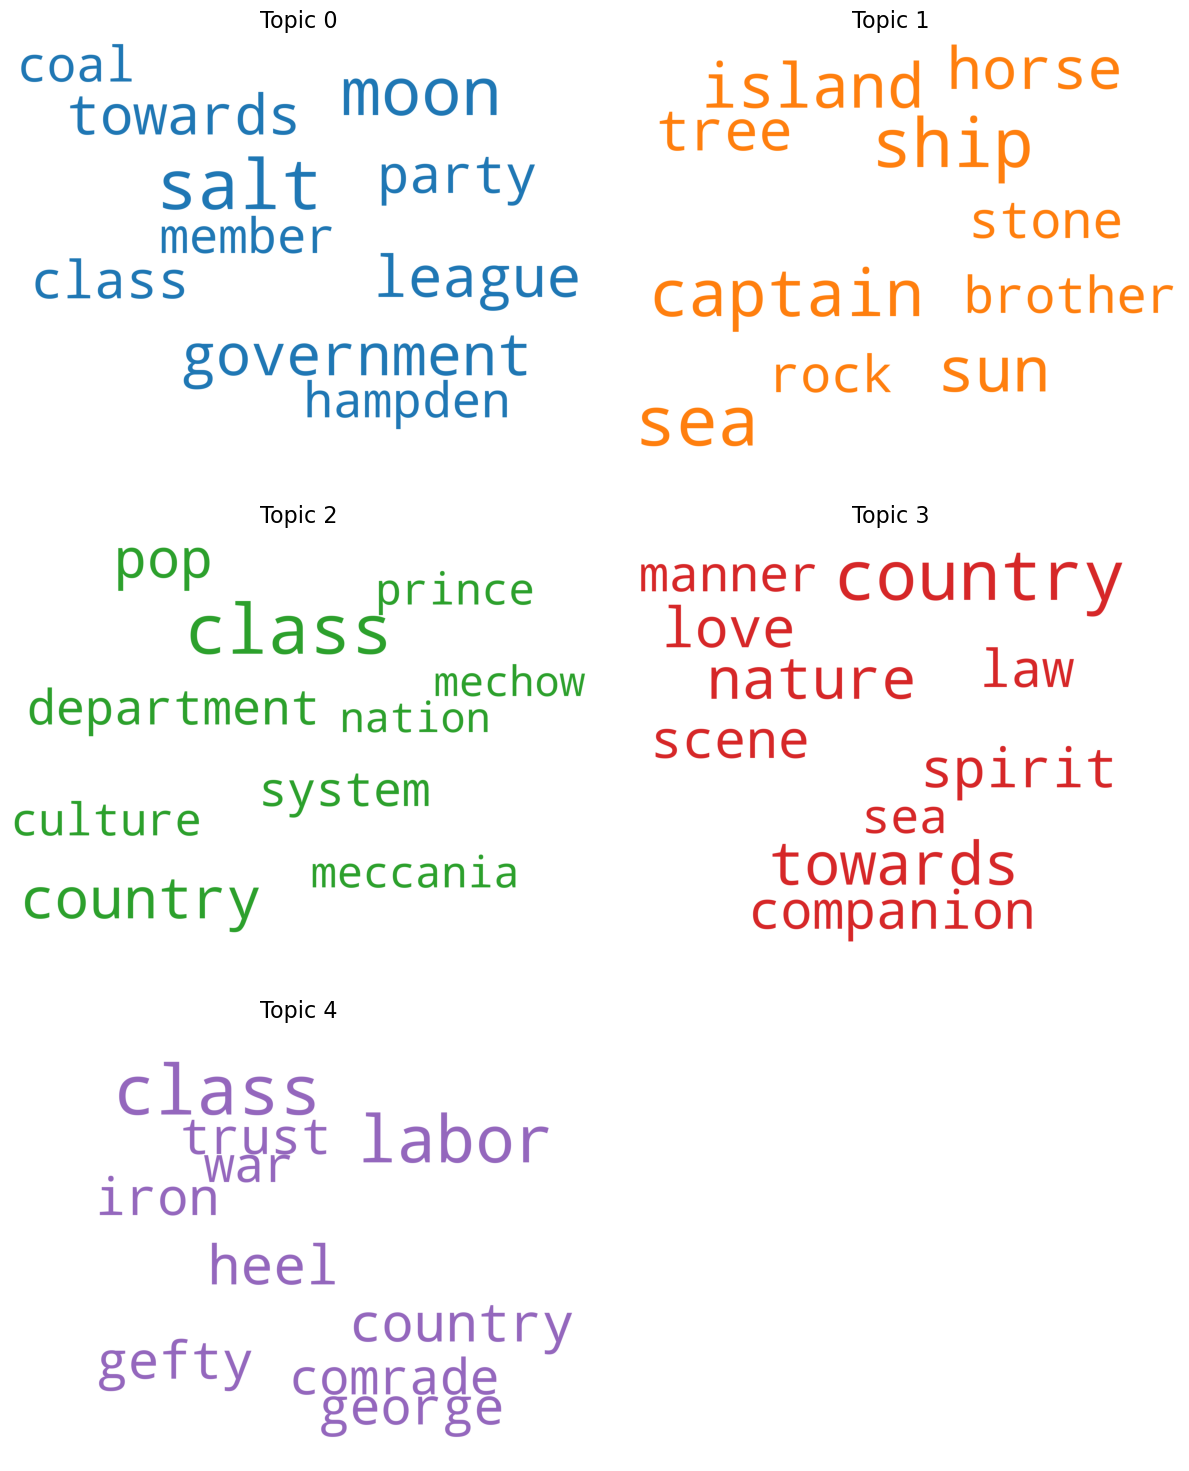

In [82]:
wordcloud(lda_science)

In [75]:
# children
lda_children = return_LDA_model(directory_path_c0, 5, 10, 200)

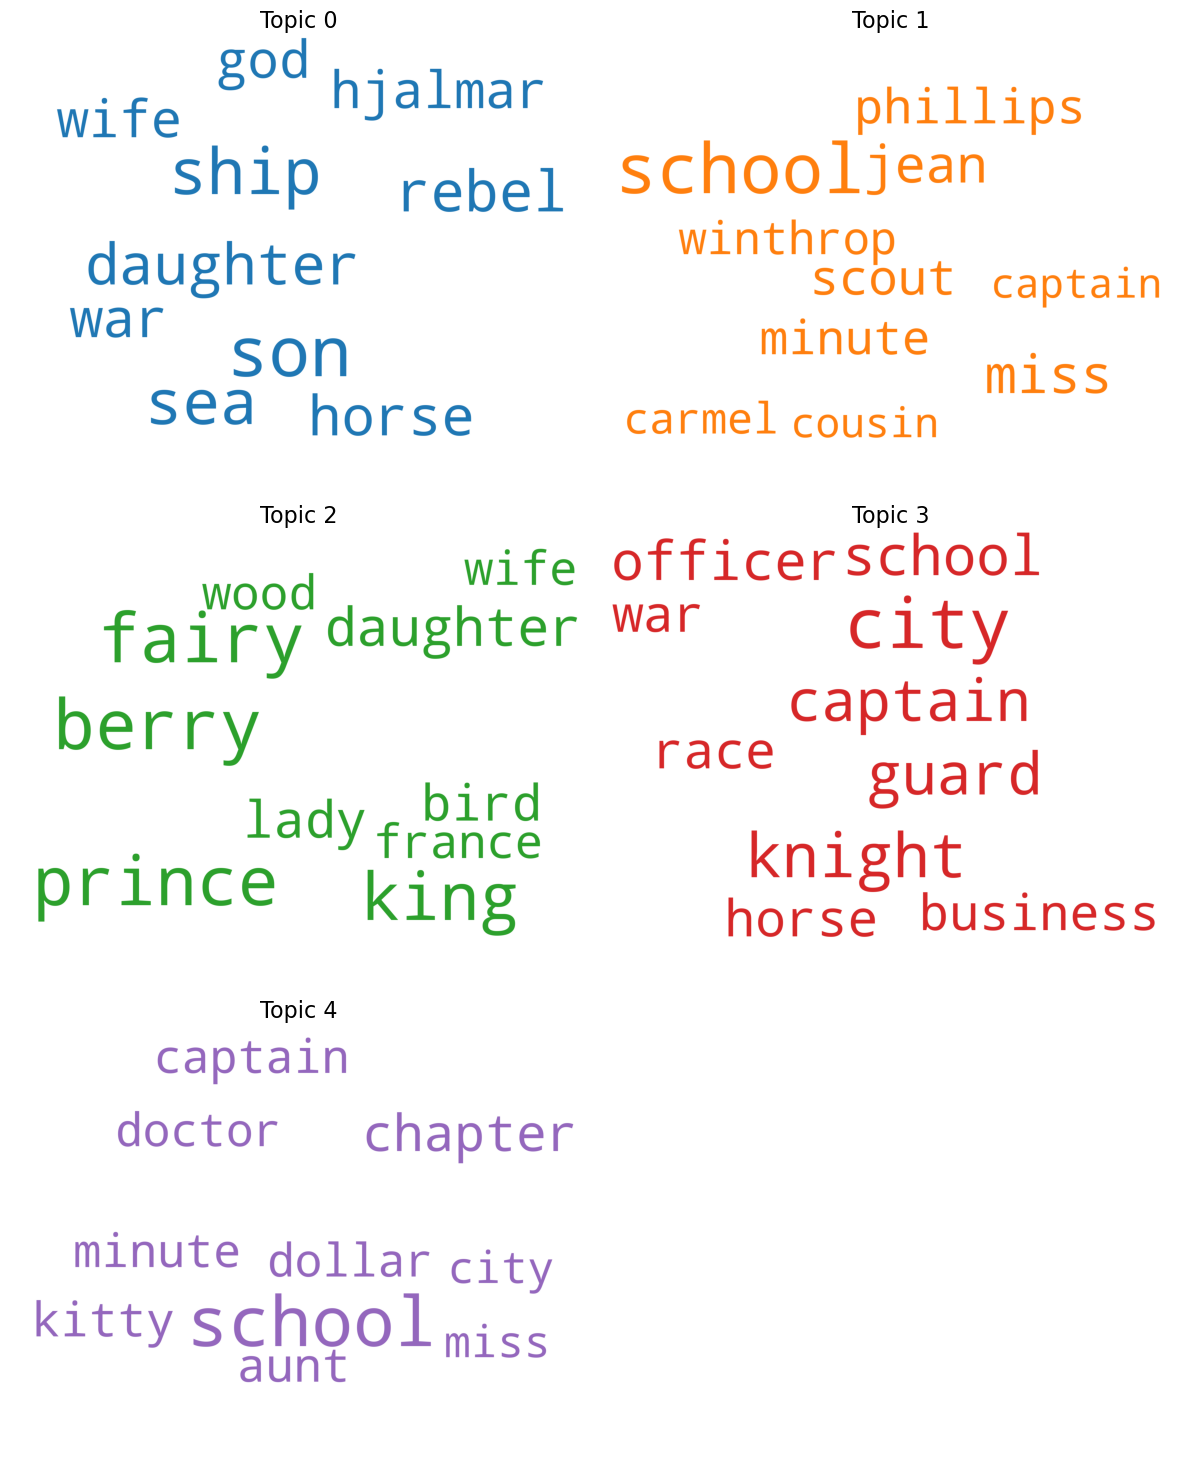

In [83]:
wordcloud(lda_children)

In [98]:
lda_fantasy = return_LDA_model(directory_path_f0, 5, 10, 200)\

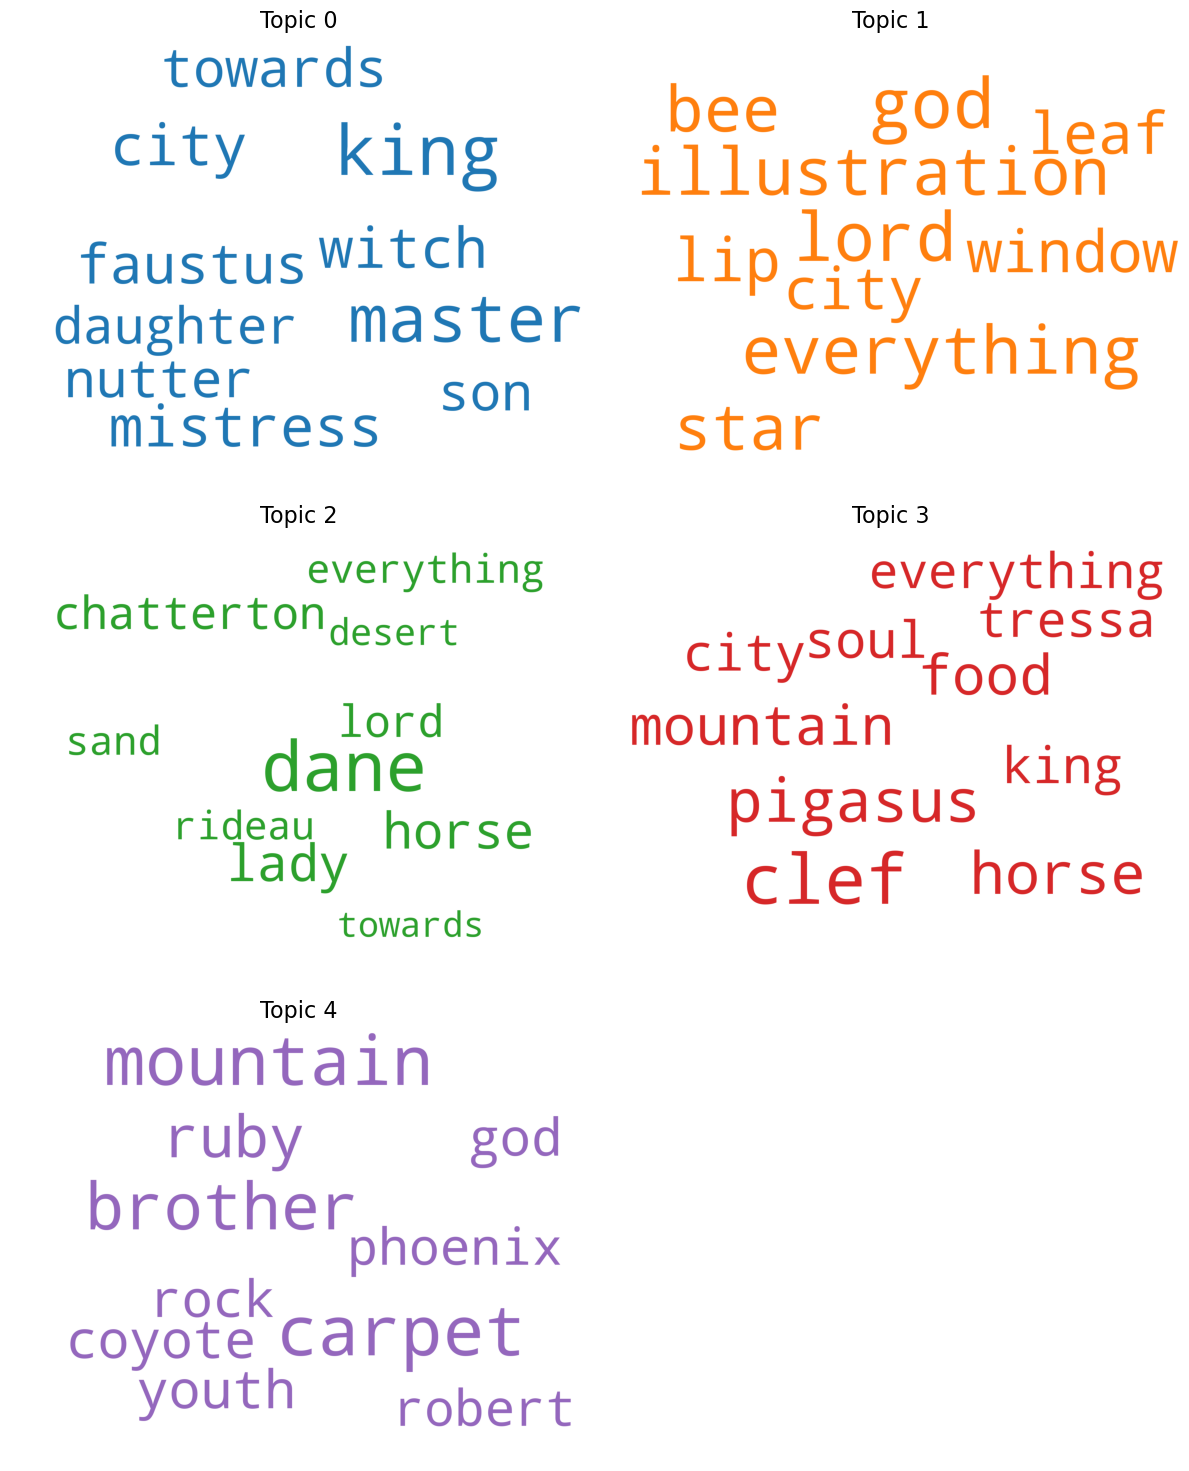

In [99]:
wordcloud(lda_fantasy)